<h1>Analysis of German credit data<h1/>

German credit data is a dataset containing information about debtors. They are classified as good/bad which suggests whether it would be a risk to give them a loan ('good' are people that will likely pay off the loan).   

Data come from the previous century. Therefore, their analysis will not be representative for the present. It may only give as a general overview on which factors are significant when it comes to this kind of scoring.   

The table constists of 21 columns, of which all can potentially influence the scoring. These are variables such as: age of the debtor, civil status (including the information on sex), credit amount, duration, the purpose.  

In my exploratory data analysis I won't analyse all factors, but I will try to determine which factors are important. Moreover, I will look into the difference in loans taken out by men and women.  

Later on I will train different Machine Learning models and try to choose appropriate metrics to evaluate the results.



<h2>Data overview<h2/>

In [1]:
#imports
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay, roc_curve, ConfusionMatrixDisplay, roc_auc_score
import sklearn.metrics
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
#reading the file
df = pd.read_csv('german_credit_data.csv',sep=';')

In [4]:
#cleaning the index
df.reset_index(inplace=True)
df.set_index('index', inplace=True)

In [5]:
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
index,,,,,,,,,,,,,,,,,,,,,
0,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,none,...,real estate,67,none,own,2,skilled,1,yes,yes,good
1,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,none,...,real estate,22,none,own,1,skilled,1,none,yes,bad
2,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male single,none,...,real estate,49,none,own,1,unskilled resident,2,none,yes,good
3,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male single,guarantor,...,life insurance,45,none,for free,1,skilled,2,none,yes,good
4,<0,24,delayed previously,new car,4870,<100,1<=X<4,3,male single,none,...,no known property,53,none,for free,2,skilled,2,none,yes,bad


In [6]:
df.columns

Index(['checking_status', 'duration', 'credit_history', 'purpose',
       'credit_amount', 'savings_status', 'employment',
       'installment_commitment', 'personal_status', 'other_parties',
       'residence_since', 'property_magnitude', 'age', 'other_payment_plans',
       'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone',
       'foreign_worker', 'class'],
      dtype='object')

We see that there are 1000 records in the table. Columns' type varies: there are objects and integers. At first sight, the type matches their content.

In [194]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   checking_status         1000 non-null   object
 1   duration                1000 non-null   int64 
 2   credit_history          1000 non-null   object
 3   purpose                 1000 non-null   object
 4   credit_amount           1000 non-null   int64 
 5   savings_status          1000 non-null   object
 6   employment              1000 non-null   object
 7   installment_commitment  1000 non-null   int64 
 8   personal_status         1000 non-null   object
 9   other_parties           1000 non-null   object
 10  residence_since         1000 non-null   int64 
 11  property_magnitude      1000 non-null   object
 12  age                     1000 non-null   int64 
 13  other_payment_plans     1000 non-null   object
 14  housing                 1000 non-null   object
 15  exist

Below, we see statistics for columns with numeric values. We may for example see that the average duration of loan is 20 months, and the median as 18 months. The longest duration is 72 months - it may be an outlier, as the value on the 75% percentile is much lower (24 months).   
When it comes to the credit amount, the average is ca. 3200 EUR. There is quite a big difference between the lowest and highest amount (250 vs. 18000).   
The other interesting column is age - the average debtor age is 35.5 years. Here there is also a big difference between the youngest and the oldest (19 vs 75).

In [7]:
df.describe()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


In [8]:
#Checking for nulls
df.isnull().values.any()

False

General check of correlation between numeric variables

In [9]:
labels_x = ['duration','credit_amount','installment_commitment', 'residence_since','age','existing_credits','num_dependents', 'foreign_worker']
correlation_matrix = df[labels_x].corr()
correlation_matrix

/var/folders/9s/y69x5fh17nz2lg8jh5f7t_mm0000gn/T/ipykernel_21762/1344557737.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df[labels_x].corr()


,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
duration,1.000000,0.624984,0.074749,0.034067,-0.036136,-0.011284,-0.023834
credit_amount,0.624984,1.000000,-0.271316,0.028926,0.032716,0.020795,0.017142
installment_commitment,0.074749,-0.271316,1.000000,0.049302,0.058266,0.021669,-0.071207
residence_since,0.034067,0.028926,0.049302,1.000000,0.266419,0.089625,0.042643
age,-0.036136,0.032716,0.058266,0.266419,1.000000,0.149254,0.118201
existing_credits,-0.011284,0.020795,0.021669,0.089625,0.149254,1.000000,0.109667
num_dependents,-0.023834,0.017142,-0.071207,0.042643,0.118201,0.109667,1.000000


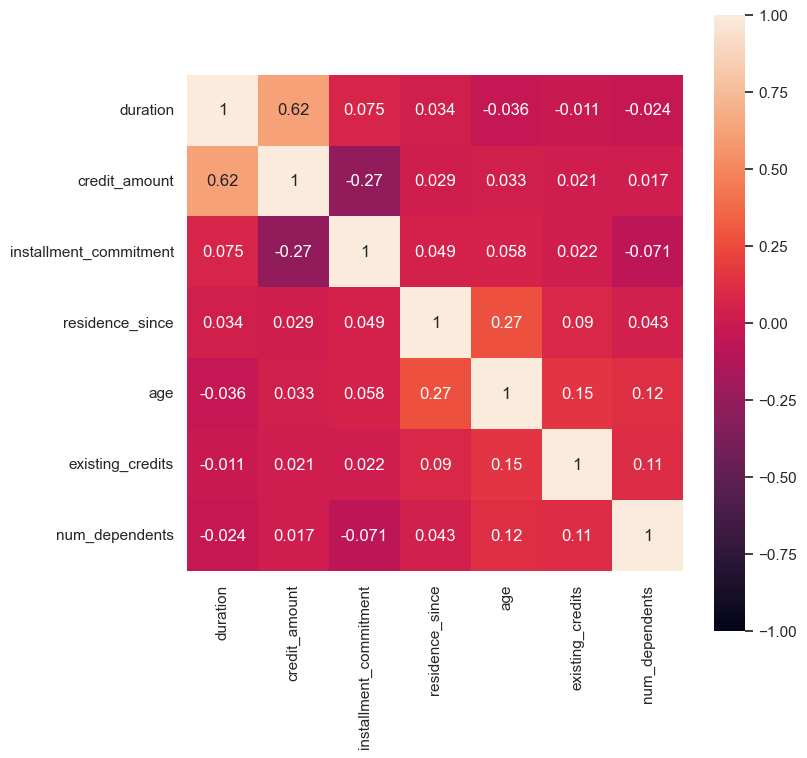

In [10]:
sns.set(rc={'figure.figsize':(8,8)}) 

sns.heatmap(
    correlation_matrix,
    vmin=-1.,
    vmax=1., 
    square=True,
    annot=True) 
pass

There is no strong correlation between any of the variables. The highest correlation is between the duration and the amount. It is not that surprising - it often takes longer to pay off higher loans. This correlation is quite close to the threshold that would classify it as high.

<h2>Exploratory Data Analysis<h2/>

We can see that 700 out of 1000 debtors got the scoring "good" which constitues 70%. The dataset is not well balanced.


In [11]:
df['class'].value_counts()

good    700
bad     300
Name: class, dtype: int64

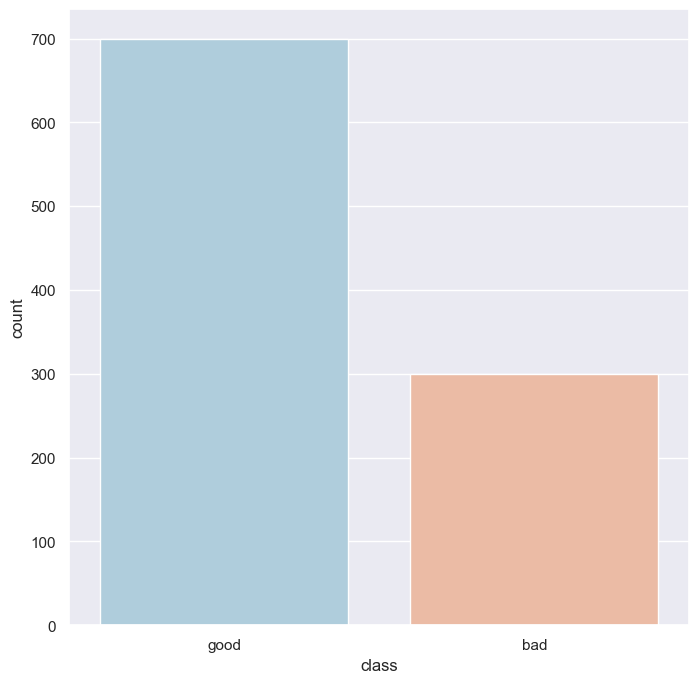

In [12]:
sns.countplot(x='class', data=df, palette='RdBu_r');

<h3>Purpose<h3/>

Let's look into the purpose of loans. What is interesting, there is a predominance of loans for radio/tv (but the most loans were for cars (when we sum up "new car" and "used car")).  
It is probably the result of the fact that the dataset includes relatively small loans.

In [13]:
df['purpose'].unique()

array(['radio/tv', 'education', 'furniture/equipment', 'new car',
       'used car', 'business', 'domestic appliance', 'repairs', 'other',
       'retraining'], dtype=object)

In [14]:
df['purpose'].value_counts().to_frame()

,purpose
radio/tv,280
new car,234
furniture/equipment,181
used car,103
business,97
education,50
repairs,22
domestic appliance,12
other,12
retraining,9


How it looks like considering the scoring?

In [15]:
purpgood = df[df['class']=='good']['purpose'].value_counts().to_frame()
purpbad = df[df['class']=='bad']['purpose'].value_counts().to_frame()


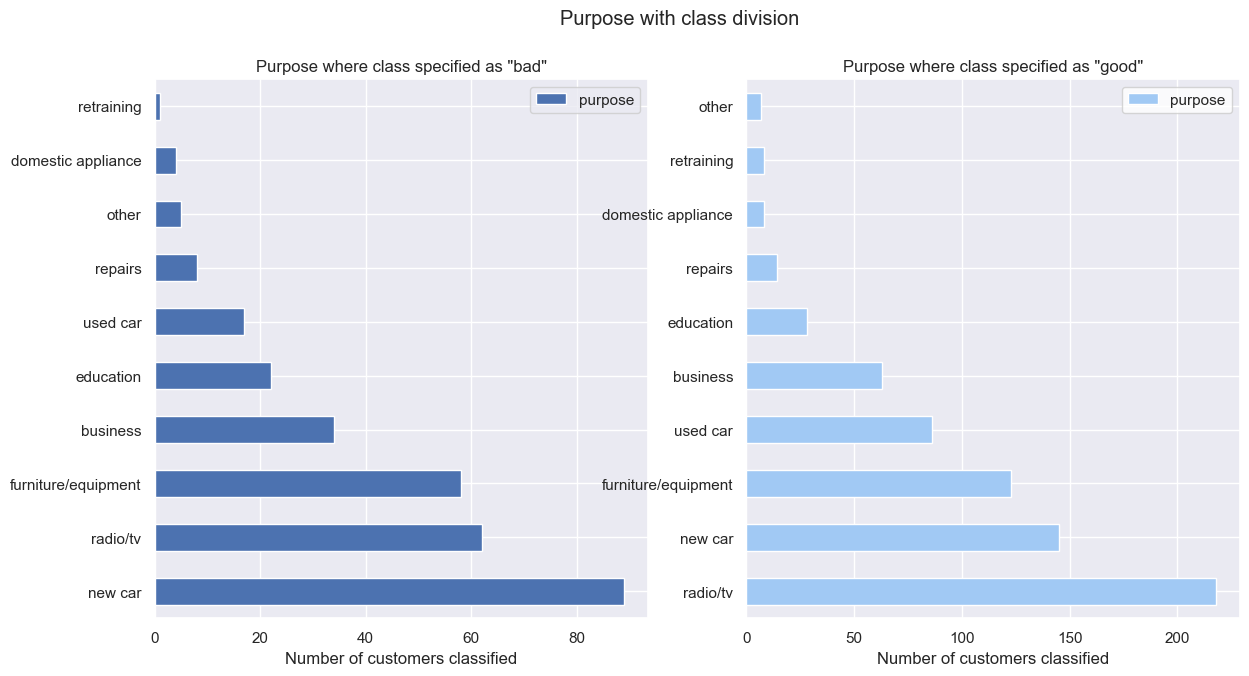

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(14,7))

purpbad.plot(kind='barh',ax = axes[0], subplots=True)
axes[0].set_title('Purpose where class specified as "bad"')
axes[0].set_xlabel('Number of customers classified')
plt.xlabel('Number of customers classified')
plt.suptitle('Purpose with class division')
sns.set_theme(style="whitegrid", palette="pastel")
purpgood.plot(kind='barh',ax = axes[1], subplots=True)
axes[1].set_title('Purpose where class specified as "good"')
axes[1].set_xlabel('Number of customers classified')

plt.show()

From the bar plots above, we may conclude that loans most considered as risky where car loans - probably because of high amounts. The most people that got a positive scoring wanted to buy a new radio/tv, so quite cheap things.

<h3>Duration<h3/>

As we can see on the histogram below, most loans were for up to 25 months. Duration does not have a normal distribution, it has almost two modes.

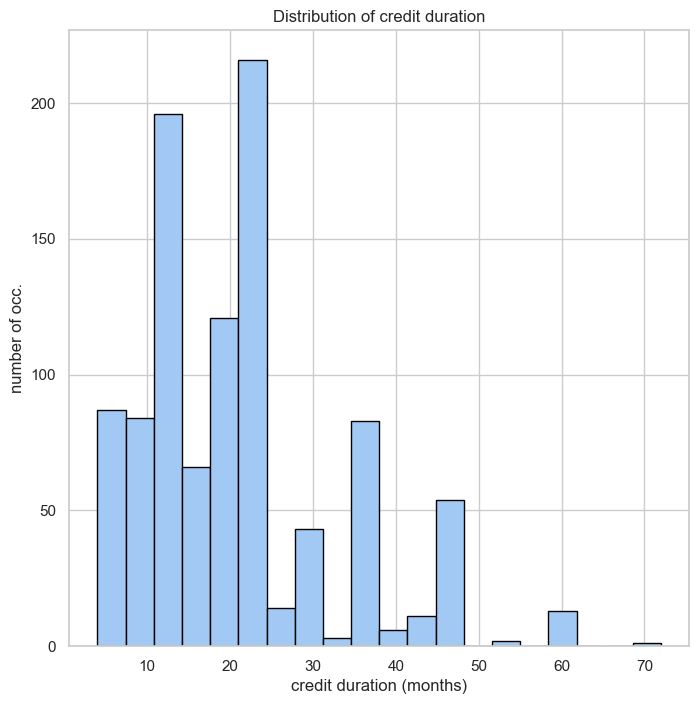

In [21]:
plt.hist(
    df['duration'],
    edgecolor="black",
    bins=20
)
plt.xlabel("credit duration (months)")
plt.ylabel("number of occ.")
plt.title('Distribution of credit duration')
plt.show()

In [22]:
long = df[df['duration']>30]
long['class'].value_counts().to_frame()

,class
good,90
bad,83


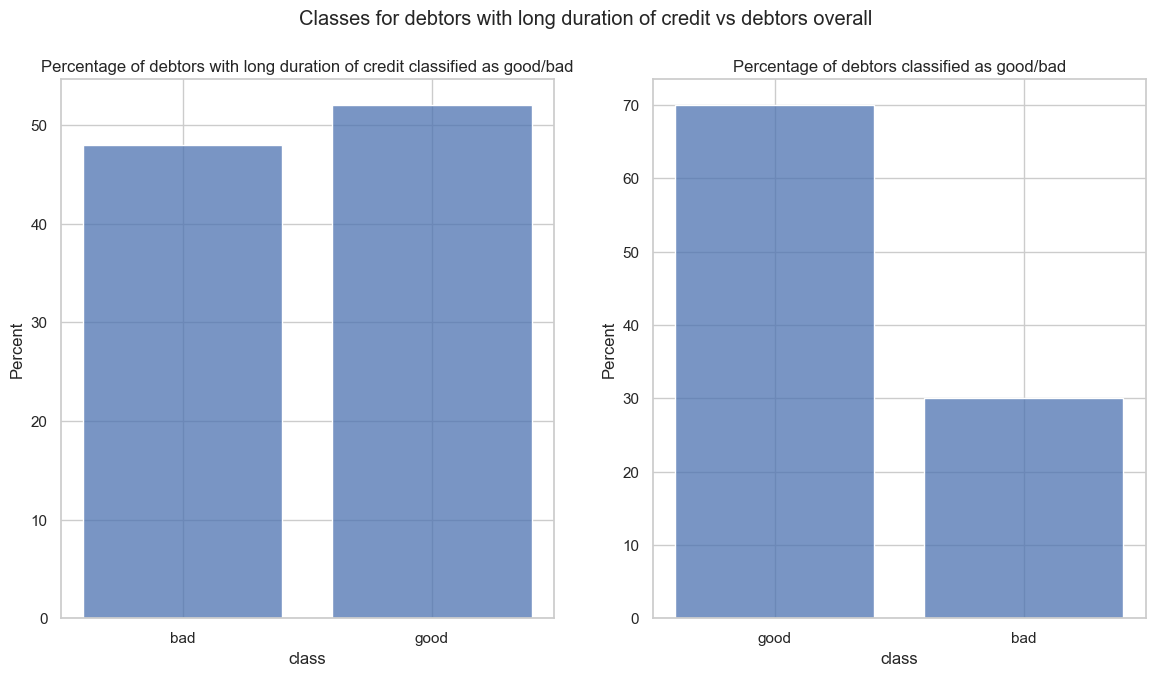

In [24]:
fig, axes = plt.subplots(nrows=1 , ncols=2, figsize=(14,7))
plt.suptitle('Classes for debtors with long duration of credit vs debtors overall')
axes[0].set_title('Percentage of debtors with long duration of credit classified as good/bad')
sns.histplot(x='class', data=long, stat='percent', shrink=0.8, ax=axes[0])
axes[1].set_title('Percentage of debtors classified as good/bad')
sns.histplot(x='class', data=df, stat='percent', shrink=0.8, ax=axes[1])

plt.show()

As we see on plots above, for people who wanted to take out a loan for a period over 30 months, scorings are almost even, which is far from the average. Almost 50% of debtors from this categories were classified as "bad". It suggests that the duration has a big influence on the scoring.

<h2>Credit amount<h2/>

In [50]:
expens = df[df['credit_amount']>5000]
expens['class'].value_counts().to_frame()

,class
good,110
bad,78


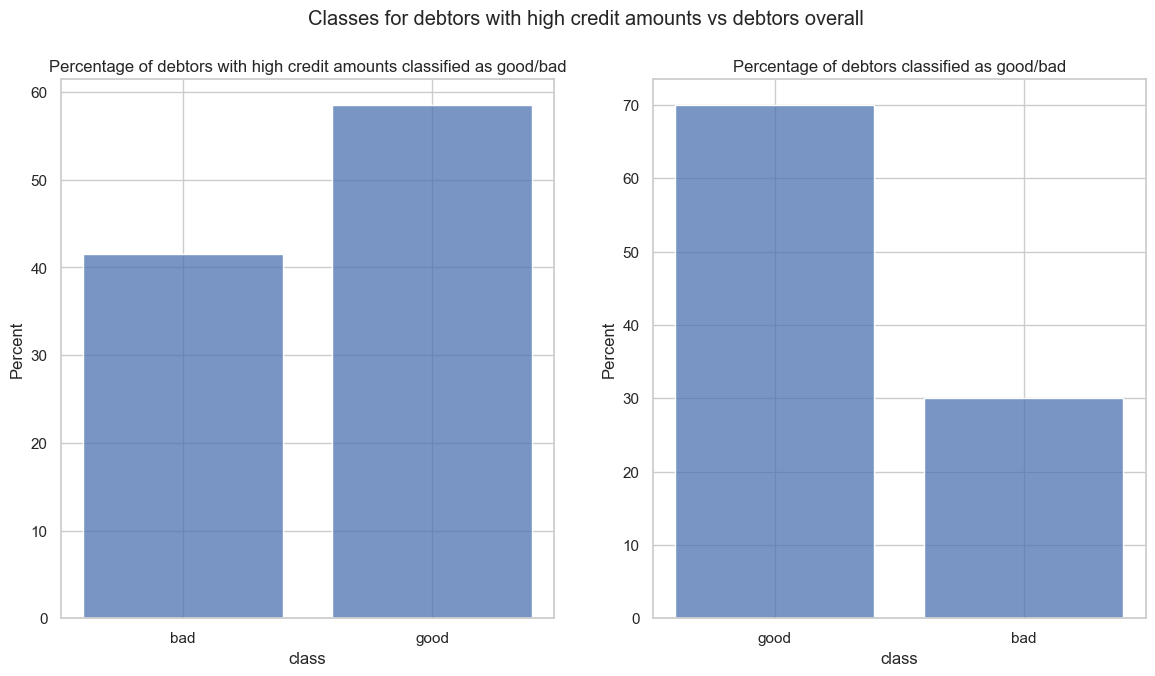

In [51]:
fig, axes = plt.subplots(nrows=1 , ncols=2, figsize=(14,7))
plt.suptitle('Classes for debtors with high credit amounts vs debtors overall')
axes[0].set_title('Percentage of debtors with high credit amounts classified as good/bad')
sns.histplot(x='class', data=expens, stat='percent', shrink=0.8, ax=axes[0])
axes[1].set_title('Percentage of debtors classified as good/bad')
sns.histplot(x='class', data=df, stat='percent', shrink=0.8, ax=axes[1])
plt.show()

As we can see on the plots above, credit amount did also influence the scoring. For those who wanted to take out a loan for over 5,000 euros, the scoring is much less favourable (difference by over 10 percent points).

<h3>Housing<h3/>

Does it matter whether a debtor has his/her own realty?

In [25]:
df.housing.value_counts().to_frame()

,housing
own,713
rent,179
for free,108


In [26]:
hasown = df[df['housing']=='own']
hasown['class'].value_counts().to_frame()

,class
good,527
bad,186


As we see on the plots below, owning a property doesn't have a very big influence on the scoring - it's a difference by only a few percent points.

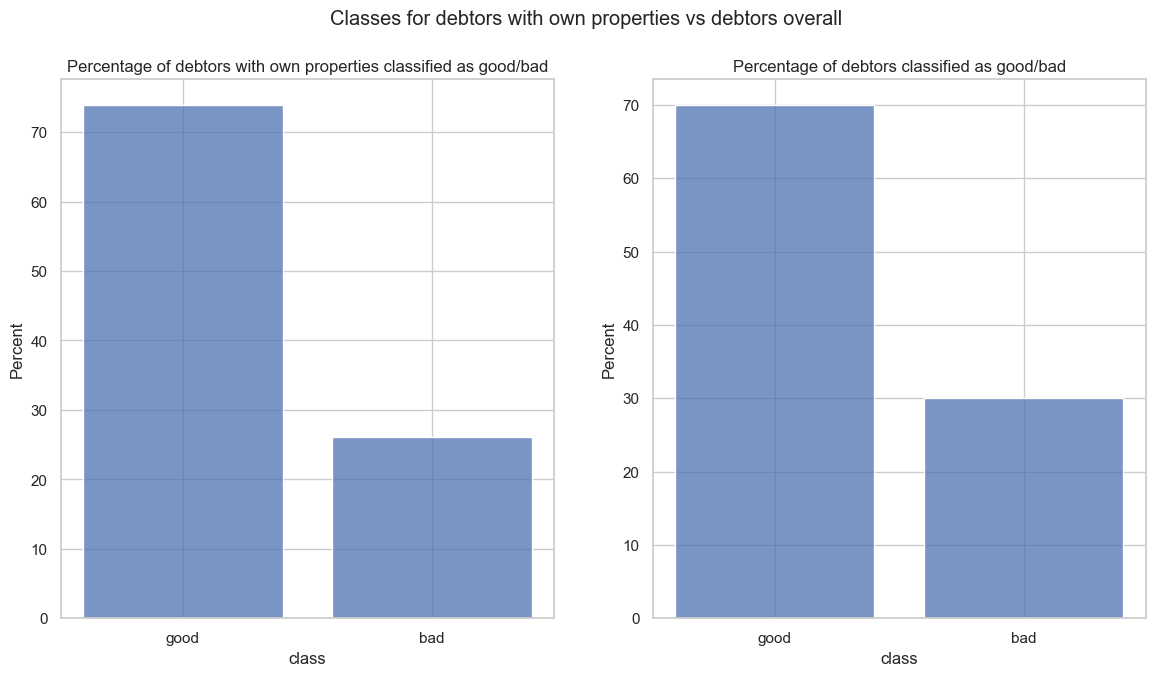

In [29]:
fig, axes = plt.subplots(nrows=1 , ncols=2, figsize=(14,7))
plt.suptitle('Classes for debtors with own properties vs debtors overall')
axes[0].set_title('Percentage of debtors with own properties classified as good/bad')
sns.histplot(x='class', data=hasown, stat='percent', shrink=0.8, ax=axes[0])
axes[1].set_title('Percentage of debtors classified as good/bad')
sns.histplot(x='class', data=df, stat='percent', shrink=0.8, ax=axes[1])

plt.show()

<h3>Employment<h3/>

From the dataset we may also learn whether debtors are qualified employees or unemployed. It seems to be a piece of information that should really influence the scoring.

In [30]:
df.job.value_counts().to_frame()

,job
skilled,630
unskilled resident,200
high qualif/self emp/mgmt,148
unemp/unskilled non res,22


Qualified and highly qualified debtors, divided by scoring:

In [31]:
qualjob = df[(df['job']=='skilled') | (df['job']=='high qualif/self emp/mgmt')]
qualjob['class'].value_counts().to_frame()


,class
good,541
bad,237


Unqualified/unemployed divided by scoring:

In [33]:
nonqual = df[(df['job']=='unskilled resident') | (df['job']=='unemp/unskilled non res')]
nonqual['class'].value_counts().to_frame()

,class
good,159
bad,63


The difference is very unsignificant - it almost doesn't matter whether a person is qualified.

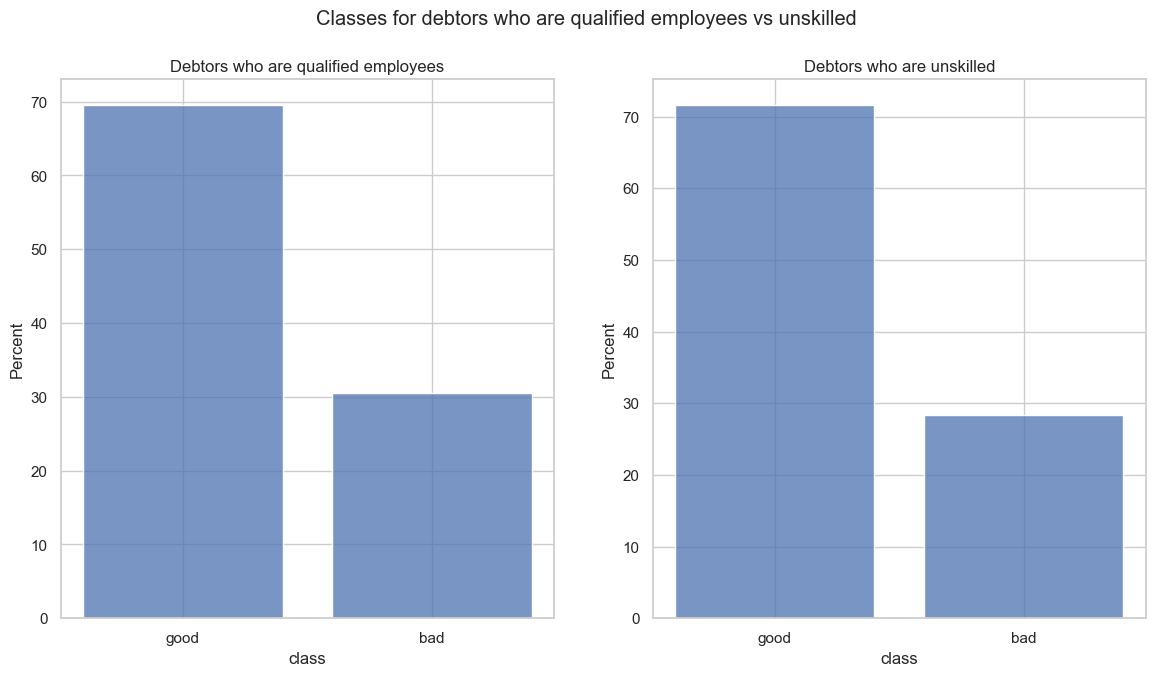

In [34]:
fig, axes = plt.subplots(nrows=1 , ncols=2, figsize=(14,7))
plt.suptitle('Classes for debtors who are qualified employees vs unskilled')
axes[0].set_title('Debtors who are qualified employees')
sns.histplot(x='class', data=qualjob, stat='percent', shrink=0.8, ax=axes[0])
axes[1].set_title('Debtors who are unskilled')
sns.histplot(x='class', data=nonqual, stat='percent', shrink=0.8, ax=axes[1])
plt.show()

When we consider only unemployed, are they classified differently?

In [37]:
df[df['employment']=='unemployed']['class'].value_counts().to_frame()

,class
good,39
bad,23


In [35]:
nowork = df[df['employment']=='unemployed']


Considering the unemployed, there is a slightly bigger difference comparing to the entire dataset. Almost 40% of unemployed were scored as "bad" (it's 30% for all debtors).

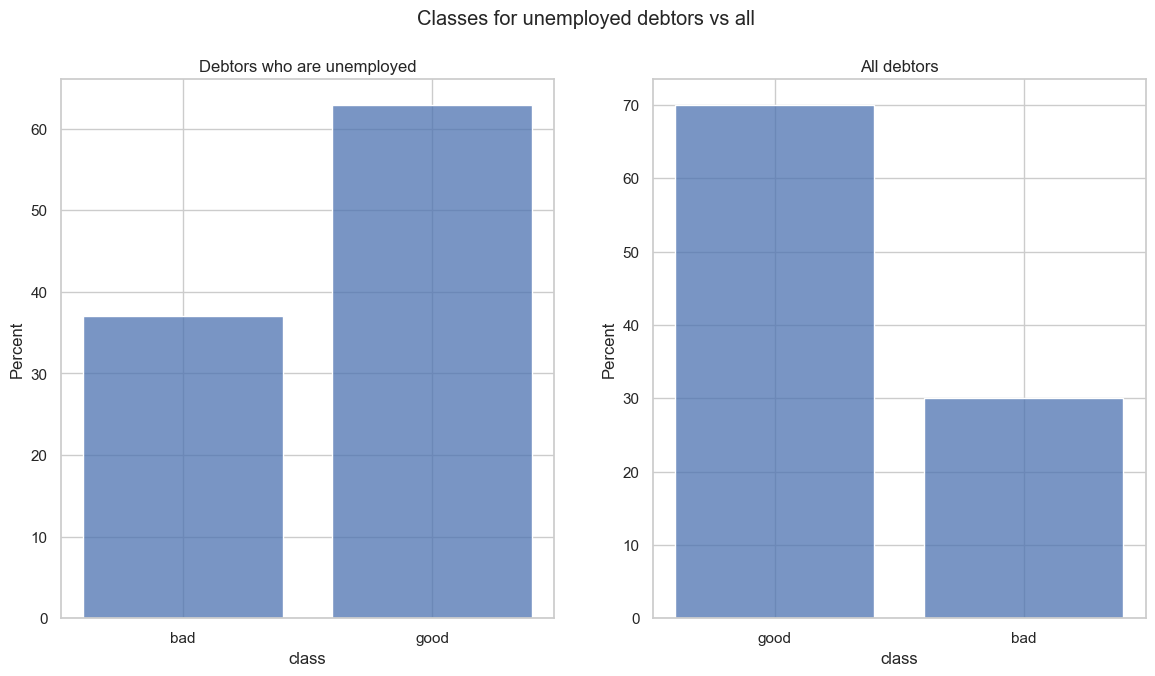

In [36]:
fig, axes = plt.subplots(nrows=1 , ncols=2, figsize=(14,7))
plt.suptitle('Classes for unemployed debtors vs all')
axes[0].set_title('Debtors who are unemployed')
sns.histplot(x='class', data=nowork, stat='percent', shrink=0.8, ax=axes[0])
axes[1].set_title('All debtors')
sns.histplot(x='class', data=df, stat='percent', shrink=0.8, ax=axes[1])
plt.show()

The column which gives us an interesting overview on the whole dataset, is "foreign worker". It turns out that almost all records regard foreign workers, not Germans.

In [38]:
df['foreign_worker'].value_counts().to_frame()

,foreign_worker
yes,963
no,37


That's why, when we filter only people classified as "foreign workers", that is the majority of records and results of the scoring are representative to the entire dataset.

In [39]:
df[df['foreign_worker']=='yes']['class'].value_counts().to_frame()

,class
good,667
bad,296


It's quite different when we filter those that are NOT foreign workers. The majority has the "good" scoring.

In [40]:
df[df['foreign_worker']=='no']['class'].value_counts().to_frame()

,class
good,33
bad,4


<h3>Analysis considering the sex<h3/>

The fact that sex is included in the personal status enables us to analyse what kind of debtors are men and women. We should remember that the dataset is quite old, so the fact that there are more men than women should not amaze us, because women were much less financially independent in the previous century than now.

In [41]:
df['personal_status'].unique()

array(['male single', 'female div/dep/mar', 'male div/sep',
       'male mar/wid'], dtype=object)

It's interesting that the onlu women that took out loans were married/divorced. In case of men, we have a much bigger range of labels, including singles.

In [42]:
female = df[df['personal_status'].str.contains('female')]
male = df[~df['personal_status'].str.contains('fe')]

In [43]:
sexc = pd.DataFrame({
    'sex': ['female','male'],
    'count': [len(female), len(male)]
})

In [44]:
sexc

,sex,count
0,female,310
1,male,690


According to expectations, there are over twice as many men as women.

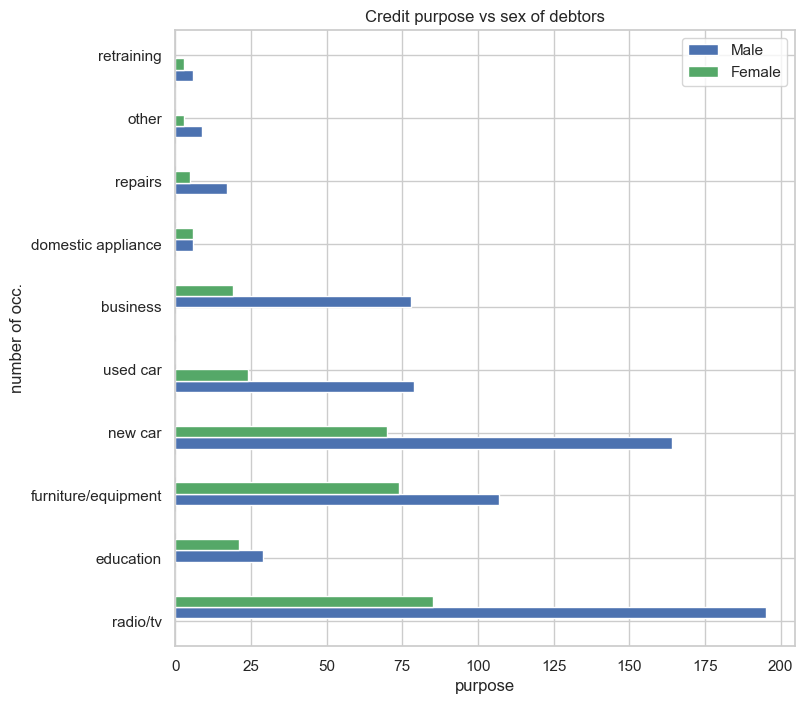

In [46]:
plt.hist(
    [male['purpose'], female['purpose']],
    bins=20,
    orientation='horizontal'
)
plt.xlabel("purpose")
plt.ylabel("number of occ.")
plt.legend(['Male','Female'],loc='upper right')
plt.title('Credit purpose vs sex of debtors')
plt.show()

For both men and women it was the most common to take out loans for radio/tv. What's interesting, for women the second most often purpose was furniture/equipment, and for men a new car.

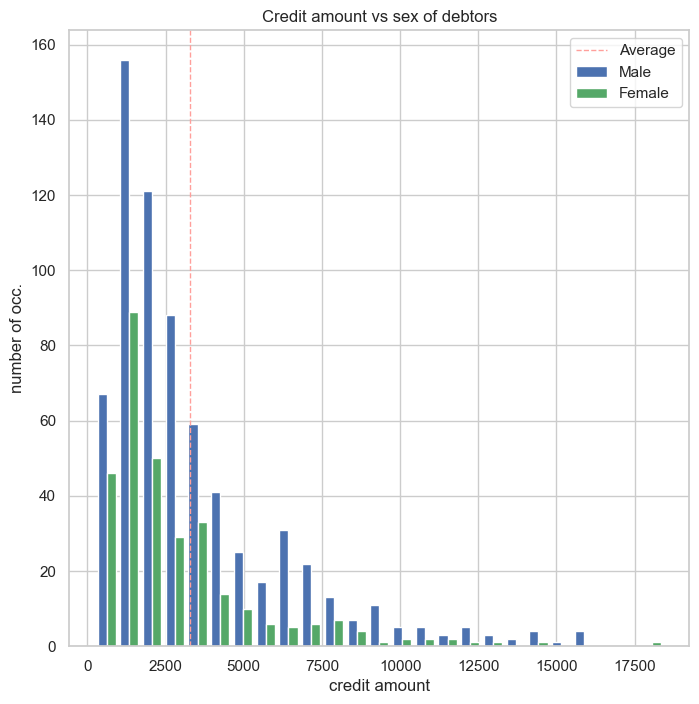

In [47]:
plt.hist(
    [male['credit_amount'], female['credit_amount']],
    bins=25,
)
plt.xlabel("credit amount")
plt.axvline(df['credit_amount'].mean(), color='r', linestyle='dashed',linewidth=1, label='Average')
plt.ylabel("number of occ.")
plt.legend(['Average','Male','Female'],loc='upper right')
plt.title('Credit amount vs sex of debtors')
plt.show()

As we can see on the above histogram (that has one mode and is right-skewed), there is not a lot of credits for high amounts. What's interesting is that the loan for over 17,000 euros was taken out by a woman.

How does the classification of women and men with regards to the scoring look like?

In [52]:
femclass = pd.pivot_table(female,index='class',values='purpose', aggfunc=len)
femclass.reset_index(inplace=True)
femclass = femclass.rename(columns={'purpose':'female'})


In [53]:
maleclass = pd.pivot_table(male,index='class',values='purpose', aggfunc=len)
maleclass.reset_index(inplace=True)
maleclass = maleclass.rename(columns={'purpose':'male'})


As we see in the table below, percentage-wise, more women got the "bad" scoring. The difference is quite significant - by almost 8 percent points.

In [54]:
totalclass = femclass.merge(maleclass, how='outer', on = 'class')

totalclass['female %'] = totalclass['female'] / totalclass['female'].sum()*100
totalclass['male %'] = totalclass['male'] / totalclass['male'].sum()*100
totalclass = totalclass.round(2)
totalclass


,class,female,male,female %,male %
0,bad,109,191,35.16,27.68
1,good,201,499,64.84,72.32


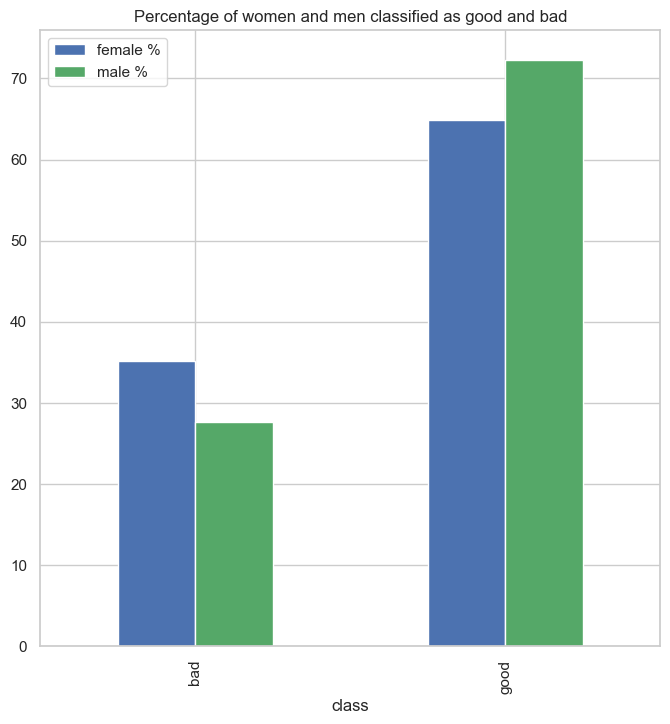

In [55]:
toplot = totalclass.drop(['female','male'], axis=1)
toplot.plot(kind='bar',x='class')
plt.title('Percentage of women and men classified as good and bad')
plt.show()

<h2>Age<h2/>

Considering the age of debtors, there are no significant differences between women and men. It may be worth noticing that the highest concentration of records is around 30 years old.

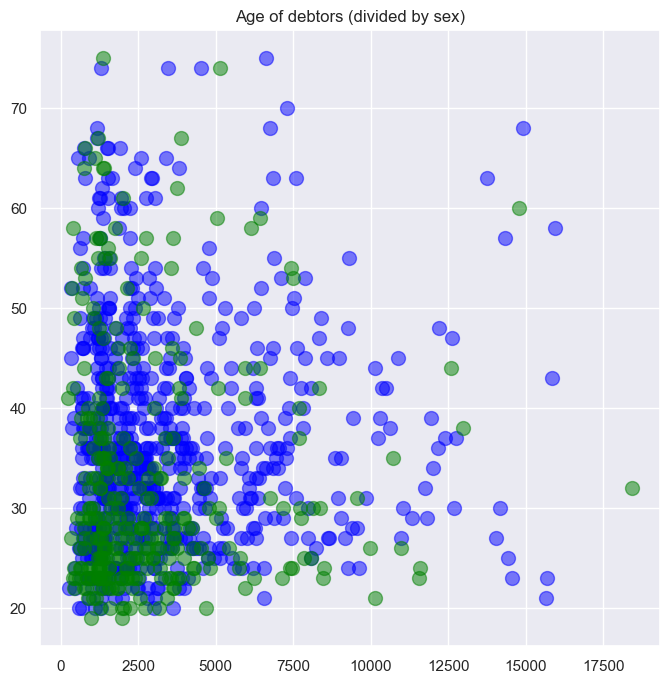

In [235]:
plt.scatter(male['credit_amount'], male['age'], s=100, color='blue', alpha=0.5)
plt.scatter(female['credit_amount'], female['age'], s=100, color='green', alpha=0.5)
plt.title('Age of debtors (divided by sex)')
plt.show()

In [56]:
young = df[df['age']<30]
young['class'].value_counts().to_frame()

,class
good,234
bad,137


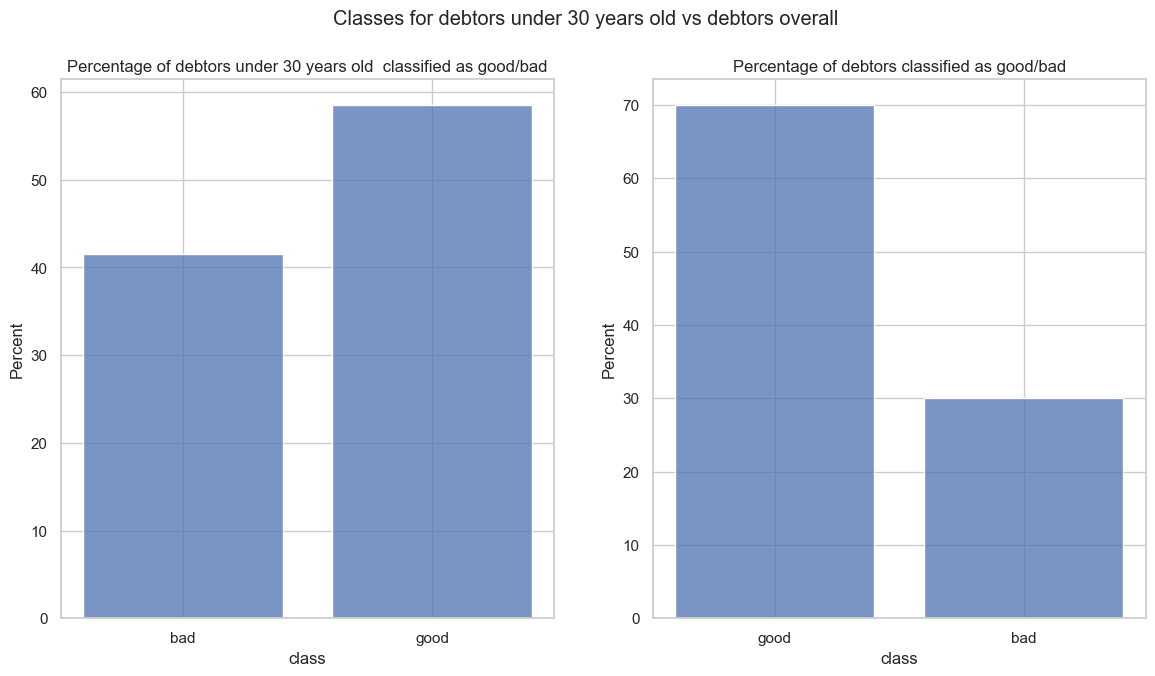

In [57]:
fig, axes = plt.subplots(nrows=1 , ncols=2, figsize=(14,7))
plt.suptitle('Classes for debtors under 30 years old vs debtors overall')
axes[0].set_title('Percentage of debtors under 30 years old  classified as good/bad')
sns.histplot(x='class', data=expens, stat='percent', shrink=0.8, ax=axes[0])
axes[1].set_title('Percentage of debtors classified as good/bad')
sns.histplot(x='class', data=df, stat='percent', shrink=0.8, ax=axes[1])
plt.show()

Based on the above plots, we may conclude that age has an influence on scoring - people under 30 years old were more often classified as "bad".

In general, we see that many factors influence our target variable (scoring). Among the most important ones, there are: credit amount, duration, sex and age.

<h3>Przygotowanie danych do modelowania<h3/>

Do modeli będę na pewno potrzebowała kolumny zawierającej płeć. Najpierw zamieniam je w taki sposób, aby były tylko dwie różne kategorie (chcę zastosować label encoder, żeby przećwiczyć jego działanie).

In [238]:
df['personal_status'].unique()

array(['male single', 'female div/dep/mar', 'male div/sep',
       'male mar/wid'], dtype=object)

In [239]:
#zamiana stanu cywilnego mężczyzn na "male"
df.loc[df['personal_status'] == 'male single', 'personal_status'] = 'male'
df.loc[df['personal_status'] == 'male div/sep', 'personal_status'] = 'male'
df.loc[df['personal_status'] == 'male mar/wid', 'personal_status'] = 'male'

In [240]:
#zamiana stanu cywilnego kobiet na "female"
df.loc[df['personal_status'] == 'female div/dep/mar', 'personal_status'] = 'female'

In [241]:
#utworzenie instancji label encodera
labelencoder = LabelEncoder()
#zamiana płci na wartości binarnej i przechowanie wyniku w nowej kolumnie
df['sex'] = labelencoder.fit_transform(df['personal_status'])

Zamieniamy również klasę na wartości binarne

In [242]:
df['Class'] = labelencoder.fit_transform(df['class'])

Zamiana kolumny foreign_worker na wartości binarne (ostatecznie zmienna nie została wykorzystana)

In [243]:
df['Foreign_worker'] = labelencoder.fit_transform(df['foreign_worker'])

In [244]:
df

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class,sex,Class,Foreign_worker
index,,,,,,,,,,,,,,,,,,,,,
0,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male,none,...,own,2,skilled,1,yes,yes,good,1,1,1
1,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female,none,...,own,1,skilled,1,none,yes,bad,0,0,1
2,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male,none,...,own,1,unskilled resident,2,none,yes,good,1,1,1
3,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male,guarantor,...,for free,1,skilled,2,none,yes,good,1,1,1
4,<0,24,delayed previously,new car,4870,<100,1<=X<4,3,male,none,...,for free,2,skilled,2,none,yes,bad,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,no checking,12,existing paid,furniture/equipment,1736,<100,4<=X<7,3,female,none,...,own,1,unskilled resident,1,none,yes,good,0,1,1
996,<0,30,existing paid,used car,3857,<100,1<=X<4,4,male,none,...,own,1,high qualif/self emp/mgmt,1,yes,yes,good,1,1,1
997,no checking,12,existing paid,radio/tv,804,<100,>=7,4,male,none,...,own,1,skilled,1,none,yes,good,1,1,1


<h3>Modelowanie regresji logistycznej<h3/>

Najpierw próbowałam stworzyć model oparty na samej płci jako X, ale model miał bardzo słabe wyniki i był słabo zbalansowany - nie radził sobie zupełnie w predykcji klasyfikacji jako "bad". Nawet mimo dodania parametru "balanced", wyniki były słabe, a krzywa ROC nie miała żadnej wartości predykcyjnej, przypominała prostą linię.  Dlatego postanowiłam zbudować model oparty na kolumnach numerycznych, które mogą potencjalnie mieć wpływ na scoring - okres kredytu, kwotę kredytu, płeć i wiek. Uważam, że te kolumny dają nam już dosyć dokładny obraz na scoring i są to czynniki najistotniejsze. Jak wykazała moja wcześniejsza analiza, czynniki takie jak zatrudnienie lub to, czy osoba ma własną nieruchomość, nie mają dużego wpływu na scoring. Również cel kredytu wydaje się być zmienną powiązaną z kwotą kredytu, która będzie tu miała większe znaczenie. Dlatego postanowiłam nie zamieniać wszystkich kolumn i nie uwzględniać ich w modelowaniu. (Sprawdziłam również model dla wszystkich kolumn numerycznych i wynik był nieznacznie gorszy, dlatego postanowiłam uwzględnić tylko wybrane zmienne)

In [245]:
labels_col = ['duration','credit_amount', 'age', 'sex']
X = np.array(df[labels_col])
y = np.array(df['Class'])
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    random_state=10, test_size=0.2
)
#manipulowałam parametrem test_size i najlepsze wyniki na teście i trainei uzyskiwane są tutaj właśnie przy test_size=0.2.


In [246]:
model = LogisticRegression(random_state=10, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=10)

In [247]:
model.score(X_train, y_train)

0.70625

In [248]:
model.score(X_test, y_test)

0.73

In [249]:
y_pred = model.predict(X_test)

In [250]:
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

W wartościach predykowanych widzimy znaczną przewagę klasy 1, czyli "good". Już nasuwa to podejrzenie, że model będzie dużo lepiej radził sobie z klasyfikacją tej klasy niż klasy 0.

Krzywa ROC i roc_auc_score  wskazują raczej na przeciętny charakter modelu. Krzywa ROC idzie dosyć mocno w stronę lewego rogu, w którym mielibyśmy do czynienia z udaną predykcją. Wartość wskazuje na ok. 77% auc_score, czyli model można uznać za całkiem dobry.

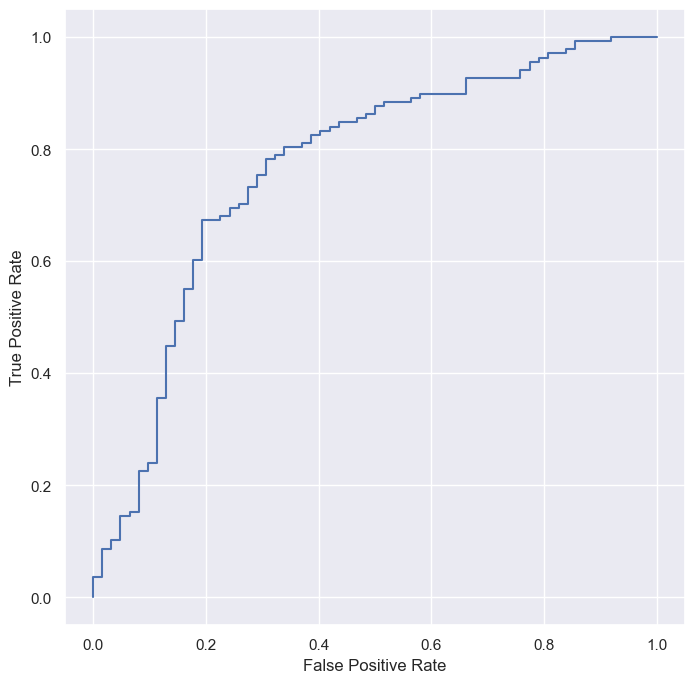

In [253]:

pred_test_proba = model.predict_proba(X_test)[:,1]
fpr_test, tpr_test, _ = roc_curve(y_test, pred_test_proba)
roc_display = RocCurveDisplay(fpr=fpr_test, tpr=tpr_test).plot()

In [254]:
roc_auc_score(y_test, pred_test_proba)

0.7658952781673679

Jak widzimy na poniższej macierzy pomyłek, model dosyć dobrze poradził sobie z poprawnym sklasyfikowaniem klasy 0. Jednak aż 53 razy sklasyfikował niepoprawnie klasę jako "good", czyli nadmiernie ocenia wartości jako 1. Precyzja dla klasy 1 jest stosunkowo niska (72%), co wskazuje na pewne przestrzelenie klasy pozytywnej. 
   
Accuracy całego modelu to 73%. Nie wydaje mi się to być bardzo dobrym wynikiem. Problemy tego modelu wynikają najprawdopodobniej z tego, że klasy są źle zbalansowane, są w stosunku 3:7, różnica między nimi powinna zapewne być mniejsza - model ma za mało danych, żeby uczyć się poprawnie przypisywać dane do tej mniej licznej klasy.  
Co ciekawe, jak dodałam do modelu na próbę kolumnę "foreign_worker", to wynik modelu pogorszył się (nie bardzo, accuracy spadło o 1%, ale różnica była). Wydaje mi się, że wynika to z tego, że ta kolumna była bardzo źle zbilansowana - większość osób była sklasyfikowana jako foreign_worker, a osoby, które miały tam "nie", miały w znacznej większości pozytywny scoring.

              precision    recall  f1-score   support

           0       0.90      0.15      0.25        62
           1       0.72      0.99      0.84       138

    accuracy                           0.73       200
   macro avg       0.81      0.57      0.54       200
weighted avg       0.78      0.73      0.65       200



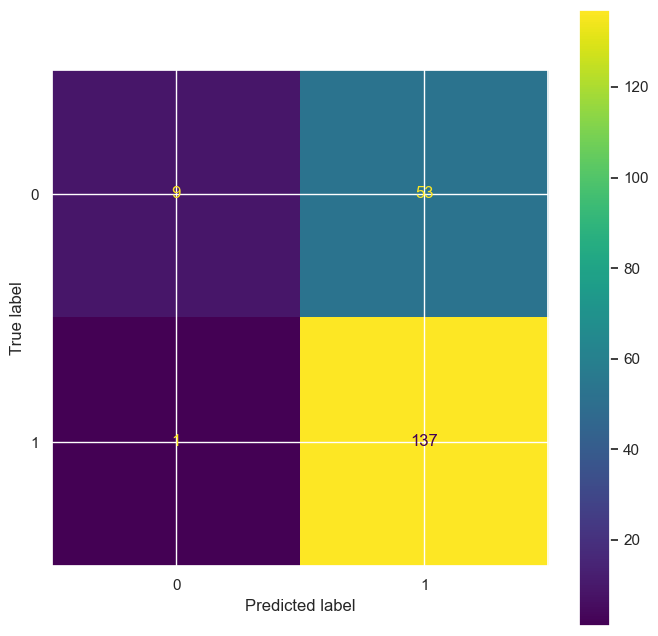

In [255]:
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

print(classification_report(y_test, y_pred))

In [256]:

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))

Accuracy: 0.73
Precision: 0.7210526315789474
Recall: 0.9927536231884058


<h3>Modelowanie drzewa decyzyjnego<h3/>

In [257]:
#utworzenie instancji drzewa decyzyjnego i podział danych na testowe i treningowe
tree_clf = DecisionTreeClassifier(random_state=100, criterion='gini')
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    random_state=100, test_size=0.25
    )

In [258]:
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=100)

W przypadku drzewa decyzyjnego widzimy tutaj zdecydowany overfitting = model ma 100% accuracy na zbiorze testowym i ok. 60% na zbiorze testowym.

In [259]:
print("Accuracy on training set: {:.2f}".format(tree_clf.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(tree_clf.score(X_test, y_test)))

Accuracy on training set: 1.00
Accuracy on test set: 0.59


Drzewo jest wielkie i nieczytelne, aż prosi się o przycięcie.

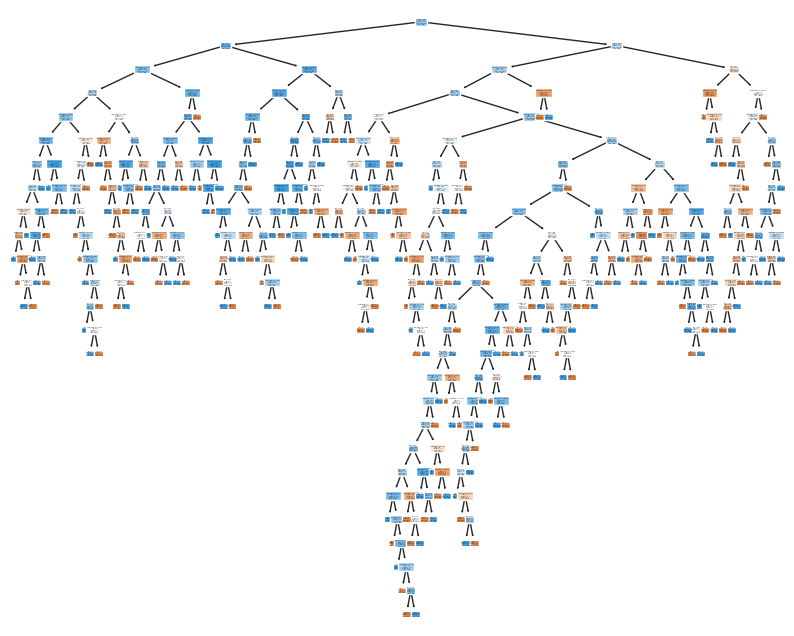

In [260]:
plt.figure(figsize=(10,8))

plot_tree(tree_clf, feature_names=labels_col, class_names=df['class'].values, filled=True);

Dopasowałam parametry metodą prób i błędów. Próbowałam zastosować random search, ale podsuwał mi parametry dające lekko gorsze accuracy.

In [261]:
tree_clf2 = DecisionTreeClassifier(max_depth=4,
                                   random_state=100, max_features=3,max_leaf_nodes=20,
                                   min_samples_leaf = 10, criterion='gini')
tree_clf2.fit(X_train, y_train)

print("Accuracy on training set: {:.2f}".format(tree_clf2.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(tree_clf2.score(X_test, y_test)))

Accuracy on training set: 0.72
Accuracy on test set: 0.69


Ograniczenie głębokości drzewa do 4 poziomów i manipulowanie innymi parametrami pomogło zniwelować overfitting. Accuracy przypomina wynik, który uzyskaliśmy przy regresji logistycznej

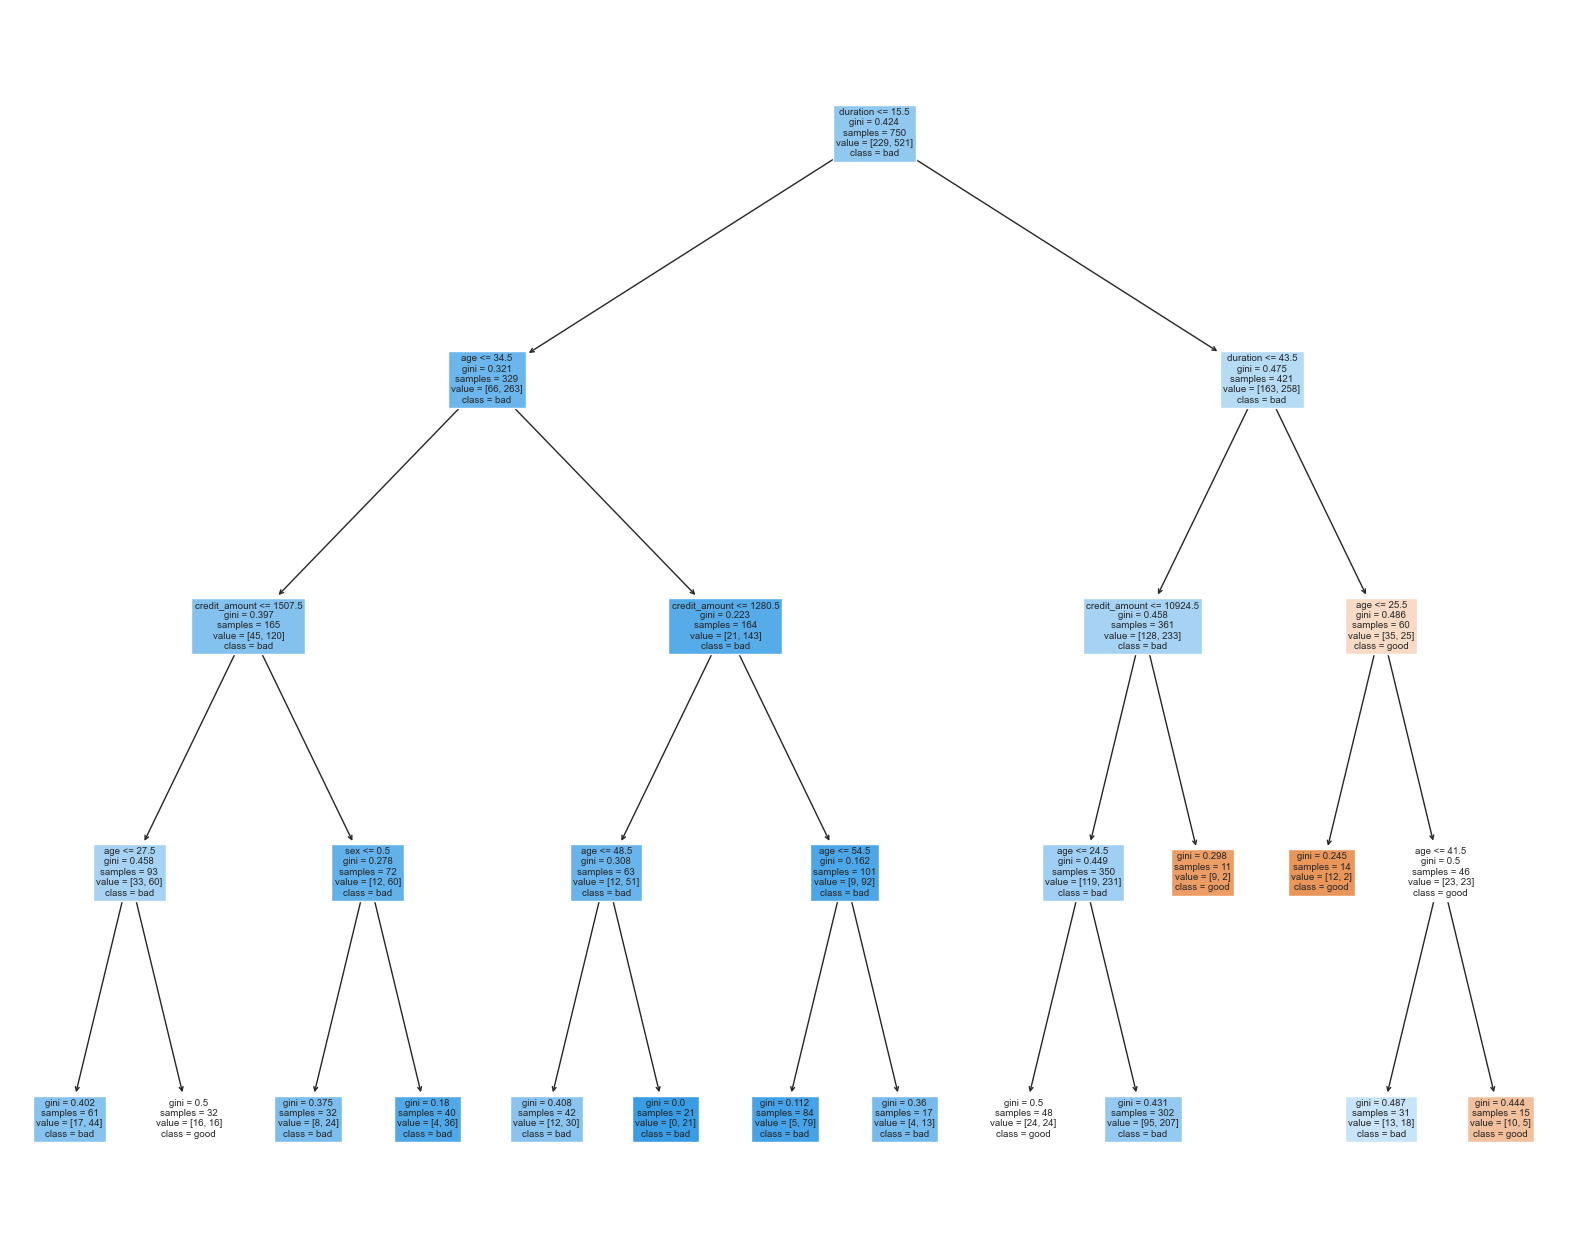

In [262]:
plt.figure(figsize=(20,16))

plot_tree(tree_clf2, feature_names=labels_col, class_names=df['class'].values,filled=True);

Jak widzimy na samym szczycie drzewa mamy "duration", które jest najistotniejszym czynnikiem przy podziale danych.

In [263]:
importances_sk = tree_clf2.feature_importances_

In [264]:
pd.DataFrame(importances_sk, labels_col)

,0
duration,0.423510
credit_amount,0.198473
age,0.359442
sex,0.018574


Co ciekawe, okazuje się, że największy wpływ na klasyfikacją miał tu okres kredytu, potem kwota, wiek. Płeć nie została wzięta pod uwagę, co można oznaczać, że słabo dzieliła dane. 

              precision    recall  f1-score   support

           0       0.39      0.17      0.24        71
           1       0.73      0.89      0.80       179

    accuracy                           0.69       250
   macro avg       0.56      0.53      0.52       250
weighted avg       0.63      0.69      0.64       250



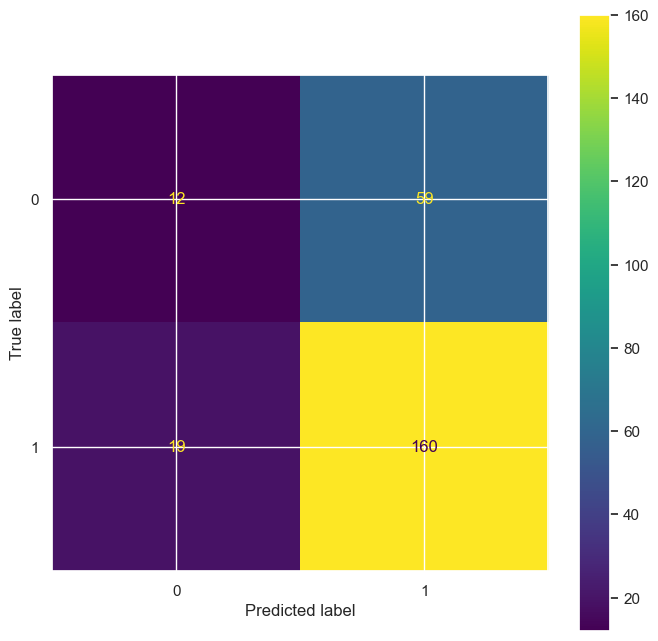

In [265]:
y_pred2 = tree_clf2.predict(X_test)
cm = confusion_matrix(y_test, y_pred2)
cm_display = ConfusionMatrixDisplay(cm).plot()

print(classification_report(y_test, y_pred2))

W przypadku drzewa decyzyjnego mamy bardzo podobne wyniki jak w przypadku regresji logistycznej. Różnica jest minimalna na niekorzyść drzewa decyzyjnego - recall, precision i accuracy są odrobinę niższe.

<h3>Który model jest lepszy w przypadku tego zbioru danych?</h3>  

  
Trudno jednoznacznie odpowiedzieć na to pytanie, ponieważ oba modele miały niemalże takie same wyniki, czyli po odpowiednim dobraniu parametrów poradziły sobie prawie tak samo (czyli dosyć przeciętnie). Jeśli chodzi o łatwość w interpretacji, to nie ma większej różnicy między nimi. Warto jednak zaznaczyć, że drzewo decyzyjne wymagało znacznego przycięcia, żeby uniknąć overfittingu, co nie było problemem w przypadku regresji logistycznej. W przypadku drzewa decyzyjnego jednoznacznie było widoczne, które zmienne miały wpływ na scoring, a które nie, co nie było jasne w przypadku regresji. Model regresji logistycznej lepiej poradził sobie w klasyfikowaniu klasy, która była mniej licznie reprezentowana w zbiorze niż drzewo decyzyjne. Wydaje mi się, że oba modele są odpowiednimi modelami do klasyfikacji.

